In [1]:
!pip install networkx


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Graph Construction

In [2]:
import pandas as pd
import networkx as nx
import numpy as np

In [3]:
df = pd.read_excel("SFHH1.xlsx")

In [4]:
G = nx.Graph()

In [5]:
edges = df[["node1", "node2"]].drop_duplicates().values.tolist()

In [6]:
G.add_edges_from(edges)

## Question 1

In [7]:
N = G.number_of_nodes() 
print("Number of Nodes: ", N)

Number of Nodes:  403


In [8]:
E = G.number_of_edges()
print("Number of Edges: ", E)

Number of Edges:  9510


In [9]:
degrees = []
for node, degree in G.degree():
    degrees.append(degree)

In [10]:
avg_degree = np.mean(degrees).round(2)
std_degree = np.std(degrees).round(2)
print("Average Degree: ", avg_degree)
print("Standard Deviation of Degrees: ", std_degree)

Average Degree:  47.2
Standard Deviation of Degrees:  29.95


## Question 2

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# sns.set_style(style = "dark")
sns.set_style("dark")
sns.set_palette("bone")

Text(0.5, 1.0, 'Degree Distribution')

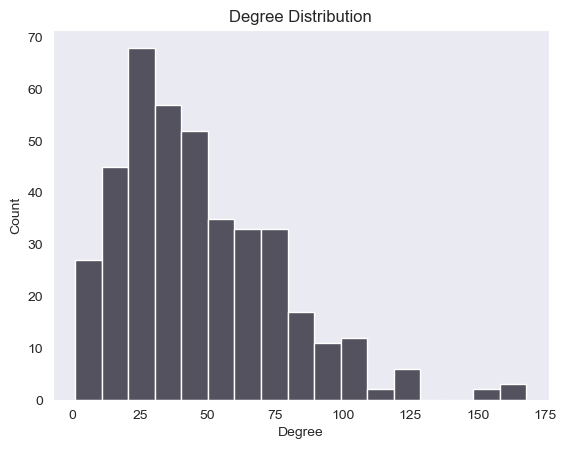

In [13]:
d_viz = sns.histplot(degrees)
d_viz.set_xlabel('Degree')
d_viz.set_ylabel('Count')
d_viz.set_title('Degree Distribution')

## Question 3

In [14]:
rho_D = nx.degree_assortativity_coefficient(G)
print("Degree assortativity: ", rho_D)

Degree assortativity:  -0.08001195267658665


## Question 4

In [15]:
C = nx.average_clustering(G)
print("Clustering coefficient: ", C)

Clustering coefficient:  0.27752342886036674


## Question 5

In [16]:
Eh = nx.average_shortest_path_length(G)
Hmax = nx.diameter(G)
print("Average Hopcount: ", Eh)
print("Diameter of Graph: ", Hmax)

Average Hopcount:  1.955211535375233
Diameter of Graph:  4


## Question 6

In [66]:
# creating a random graph
R_g = nx.gnm_random_graph(N, E)

In [67]:
C_rand_mean = -1
Eh_rand_mean = -1
C_rand = []
Eh_rand = []

for _ in range(20):
    C_rand.append(nx.average_clustering(R_g))
    Eh_rand.append(nx.average_shortest_path_length(R_g))
    
C_rand_mean = np.mean(C_rand)
Eh_rand_mean = np.mean(Eh_rand)

print("Random Graph Clustering (mean of 20):", C_rand_mean)
print("Random Graph Average Hopcount (mean of 20):", Eh_rand_mean)

Random Graph Clustering (mean of 20): 0.11751863224111021
Random Graph Average Hopcount (mean of 20): 1.8860906386183225


Since C of our graph > random graph and path length is similar, we can conclude that the graph does follow small world property.

## Question 7


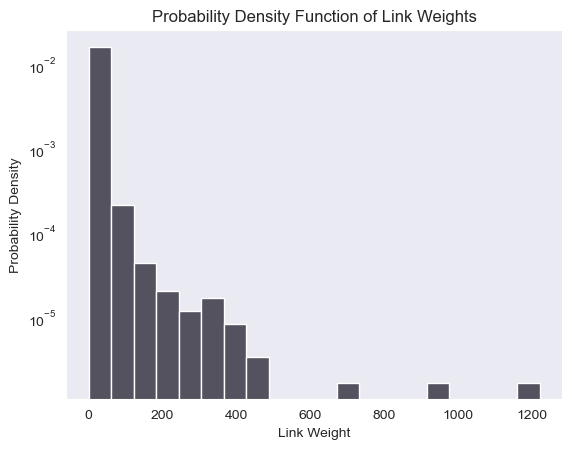

In [19]:
link_weights = df.groupby(['node1', 'node2']).size().values

# plt.figure(figsize=(10, 6))
sns.histplot(link_weights, bins=20, stat='density')
plt.xlabel('Link Weight')
plt.ylabel('Probability Density')
plt.title('Probability Density Function of Link Weights')
plt.yscale('log') 
plt.show()

## Question 8

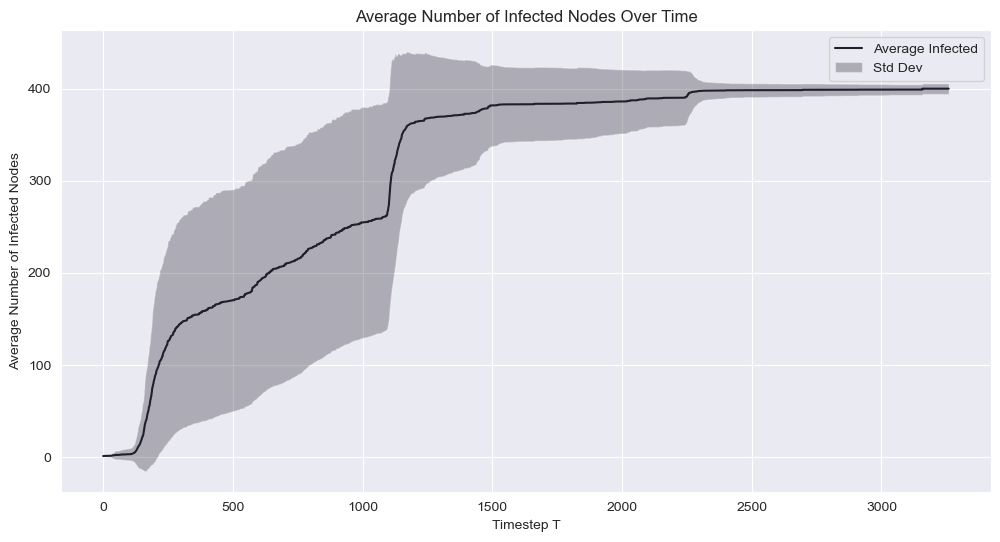

In [31]:
# Setup
df_sorted = df.sort_values('timestamp')
all_nodes = list(G.nodes())
T = df_sorted['timestamp'].max()
node_index = {node: i for i, node in enumerate(all_nodes)} 
N = len(all_nodes)

contacts_by_time = {t: g[['node1','node2']].values 
                    for t, g in df_sorted.groupby('timestamp')}

# Store infection counts for each iteration
infTime_all = np.zeros((N, T+1))
infection_times = np.full((N, N), np.inf)

for idx, seed in enumerate(all_nodes):
    infected = set([seed])
    infected_time = {seed: 0}
    infTime = np.zeros(T+1)
    infTime[0] = 1

    for t in range(1, T+1):
        contacts = contacts_by_time.get(t, [])
        new_infected = set()
        for n1, n2 in contacts:
            if n1 in infected and n2 not in infected:
                new_infected.add(n2)
                infected_time[n2] = t
            elif n2 in infected and n1 not in infected:
                new_infected.add(n1)
                infected_time[n1] = t
        infected.update(new_infected)
        infTime[t] = len(infected)
        
    infTime_all[idx] = infTime
    
    for node, t_inf in infected_time.items():
        infection_times[idx, node_index[node]] = t_inf
        
# Calculate average and std deviation over all seeds
avg_inf = infTime_all.mean(axis=0)
std_inf = infTime_all.std(axis=0)

# Plot
plt.figure(figsize=(12,6))
plt.plot(range(T+1), avg_inf, label='Average Infected')
plt.fill_between(range(T+1), avg_inf-std_inf, avg_inf+std_inf, alpha=0.3, label='Std Dev')
plt.xlabel('Timestep T')
plt.ylabel('Average Number of Infected Nodes')
plt.title('Average Number of Infected Nodes Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Question 9

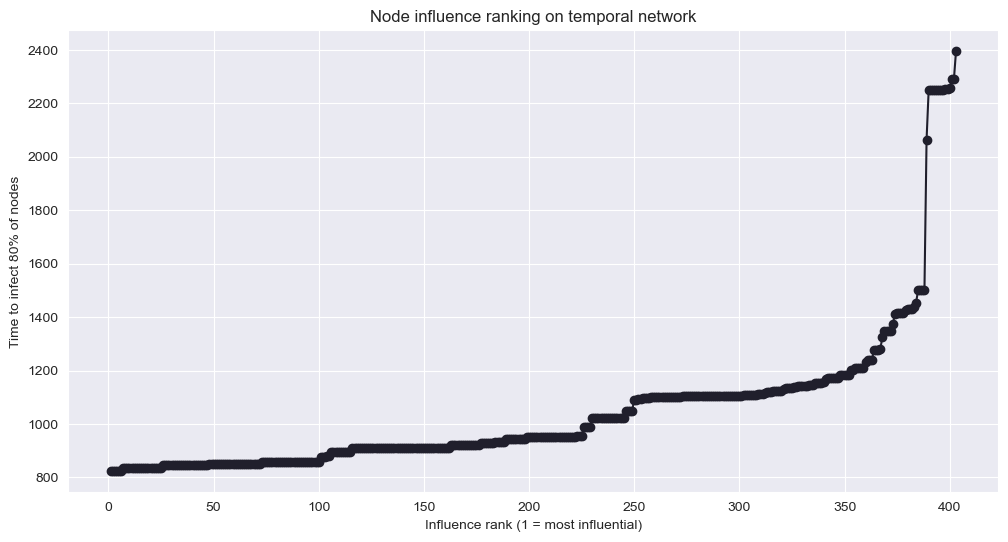

In [39]:

threshold = int(0.8 * N)   # 80% of all nodes
times_to_threshold = []

for idx, seed in enumerate(all_nodes):
    infected_counts = infTime_all[idx, :]
    reach_times = np.where(infected_counts >= threshold)[0]
    if len(reach_times) > 0:
        t_star = reach_times[0]   # first time reaching 80%
    else:
        t_star = np.inf           # never reached threshold
    times_to_threshold.append((seed, t_star))

# Sort by time to reach 80%
times_to_threshold.sort(key=lambda x: x[1])

# Ranking vector R (node indices in order of influence)
R = [seed for seed, _ in times_to_threshold]

# Sorted times for plotting
sorted_times = [t for _, t in times_to_threshold]

# Plot influence ranking
plt.figure(figsize=(12,6))
plt.plot(range(1, N+1), sorted_times, marker='o', linestyle='-')
plt.xlabel("Influence rank (1 = most influential)")
plt.ylabel("Time to infect 80% of nodes")
plt.title("Node influence ranking on temporal network")
plt.grid(True)
plt.show()


## Question 10

In [22]:

degrees = dict(G.degree())

strengths = {}

first_contact_times = {}
Z = []

for node in G.nodes():
    strength = 0
    for neighbor in G.neighbors(node):
        contacts = df[((df['node1'] == node) & (df['node2'] == neighbor)) | 
                     ((df['node1'] == neighbor) & (df['node2'] == node))].shape[0]
        strength += contacts
    strengths[node] = strength

degree_sorted = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
D = [node for node, _ in degree_sorted]

strength_sorted = sorted(strengths.items(), key=lambda x: x[1], reverse=True)
S = [node for node, _ in strength_sorted]

In [55]:
def get_random_top_f(ranking_list, f, num_iterations=1000):

    n_nodes = len(ranking_list)
    top_f_size = int(f * n_nodes)
    
    if ranking_list == D:
        values = [degrees[node] for node in ranking_list]
    elif ranking_list == S:
        values = [strengths[node] for node in ranking_list]
    elif ranking_list == Z:
        values = [first_contact_times[node] for node in ranking_list]
    else:
        values = list(range(len(ranking_list), 0, -1))
    
    # Sort values: descending for degree/strength, ascending for first contact time
    if ranking_list == Z:
        unique_values = sorted(set(values))  # ascending for first contact time
    else:
        unique_values = sorted(set(values), reverse=True)  # descending for degree/strength
    value_counts = {}
    for val in unique_values:
        value_counts[val] = values.count(val)
    
    cumulative_count = 0
    tie_needed = False
    tie_value = None
    fixed_nodes = []
    
    for val in unique_values:
        if cumulative_count + value_counts[val] <= top_f_size:
            nodes_with_val = [node for node, node_val in zip(ranking_list, values) if node_val == val]
            fixed_nodes.extend(nodes_with_val)
            cumulative_count += value_counts[val]
        else:
            tie_needed = True
            tie_value = val
            break
    
    if not tie_needed:
        return [fixed_nodes] * num_iterations
    
    tie_nodes = [node for node, node_val in zip(ranking_list, values) if node_val == tie_value]
    remaining_slots = top_f_size - len(fixed_nodes)
    
    random_selections = []
    for _ in range(num_iterations):
        selected_tie_nodes = np.random.choice(tie_nodes, remaining_slots, replace=False)
        random_selections.append(fixed_nodes + list(selected_tie_nodes))
    
    return random_selections


f_values = np.arange(0.05, 0.55, 0.05)
rRD_values = []
rRS_values = []

for f in f_values:

    top_f_size = int(f * N)
    R_f = set(R[:top_f_size])
    
    D_f_iterations = get_random_top_f(D, f)
    rRD_rates = []
    for D_f_nodes in D_f_iterations:
        D_f = set(D_f_nodes)
        rate = len(R_f.intersection(D_f)) / len(R_f)
        rRD_rates.append(rate)
    rRD_values.append(np.mean(rRD_rates))
    
    S_f_iterations = get_random_top_f(S, f)
    rRS_rates = []
    for S_f_nodes in S_f_iterations:
        S_f = set(S_f_nodes)
        rate = len(R_f.intersection(S_f)) / len(R_f)
        rRS_rates.append(rate)
    rRS_values.append(np.mean(rRS_rates))

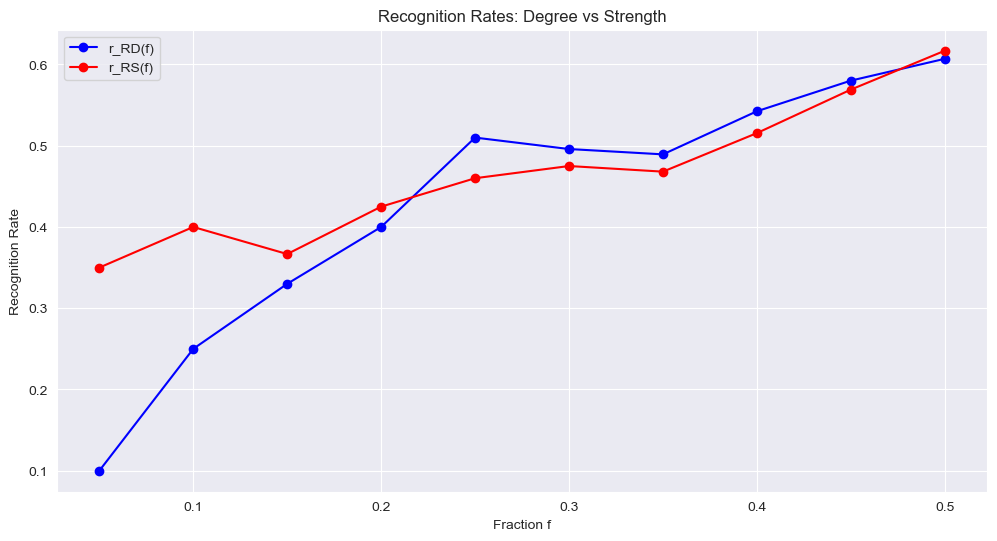

In [40]:
# Plot recognition rates
plt.figure(figsize=(12, 6))
plt.plot(f_values, rRD_values, 'bo-', label='r_RD(f)')
plt.plot(f_values, rRS_values, 'ro-', label='r_RS(f)')
plt.xlabel('Fraction f')
plt.ylabel('Recognition Rate')
plt.title('Recognition Rates: Degree vs Strength')
plt.legend()
plt.grid(True)
plt.show()

## Question 11

In [25]:
first_contact_times = {}

for node in G.nodes():
    node_contacts = df[(df['node1'] == node) | (df['node2'] == node)]
    first_contact_times[node] = node_contacts['timestamp'].min()

first_contact_sorted = sorted(first_contact_times.items(), key=lambda x: x[1])
Z = [node for node, _ in first_contact_sorted]

rRZ_values = []

for f in f_values:
    top_f_size = int(f * N)
    R_f = set(R[:top_f_size])
    
    Z_f_iterations = get_random_top_f(Z, f)
    rRZ_rates = []
    for Z_f_nodes in Z_f_iterations:
        Z_f = set(Z_f_nodes)
        rate = len(R_f.intersection(Z_f)) / len(R_f)
        rRZ_rates.append(rate)
    rRZ_values.append(np.mean(rRZ_rates))

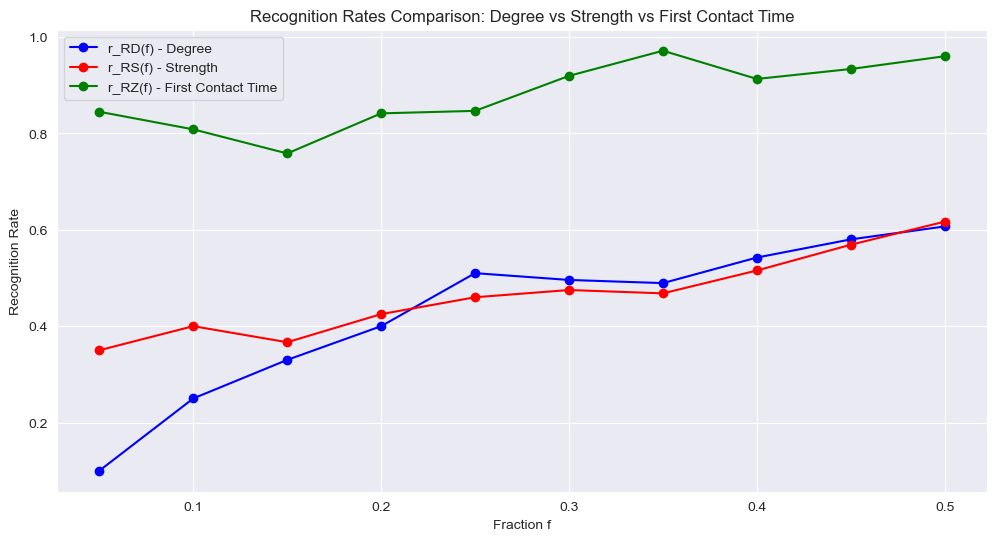

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(f_values, rRD_values, 'bo-', label='r_RD(f) - Degree')
plt.plot(f_values, rRS_values, 'ro-', label='r_RS(f) - Strength')
plt.plot(f_values, rRZ_values, 'go-', label='r_RZ(f) - First Contact Time')
plt.xlabel('Fraction f')
plt.ylabel('Recognition Rate')
plt.title('Recognition Rates Comparison: Degree vs Strength vs First Contact Time')
plt.legend()
plt.grid(True)
plt.show()

## Question 12

In [ ]:
threshold_20 = int(0.2 * N)   # to reach 20% of the nodes
times_to_20 = []

for idx, seed in enumerate(all_nodes):
    infected_counts = infTime_all[idx, :]
    reach_times = np.where(infected_counts >= threshold_20)[0]
    if len(reach_times) > 0:
        t_star = reach_times[0]
    else:
        t_star = np.inf
    times_to_20.append((seed, t_star))

# sort by time to reach 20%
times_to_20.sort(key=lambda x: x[1])
R_star = [seed for seed, _ in times_to_20]

In [61]:
avg_times_80 = []
for idx, seed in enumerate(all_nodes):
    times = infection_times[idx, :]
    finite_times = times[np.isfinite(times)]
    if len(finite_times) == 0:
        avg_time = np.inf
    else:
        cutoff = int(0.8 * N)
        if cutoff == 0: 
            cutoff = 1
        earliest_80 = np.sort(finite_times)[:cutoff]
        avg_time = np.mean(earliest_80)
    avg_times_80.append((seed, avg_time))

# sort by time to reach 80%
avg_times_80.sort(key=lambda x: x[1])
R_prime = [seed for seed, _ in avg_times_80]

In [62]:
# R vs R*
rR_Rstar_values = []
for f in f_values:
    top_f_size = int(f * N)
    R_f = set(R[:top_f_size])
    Rstar_f_iters = get_random_top_f(R_star, f, 1000)
    rates = []
    for nodes in Rstar_f_iters:
        rate = len(R_f.intersection(set(nodes))) / len(R_f)
        rates.append(rate)
    rR_Rstar_values.append(np.mean(rates))

# R vs R′
rR_Rprime_values = []
for f in f_values:
    top_f_size = int(f * N)
    R_f = set(R[:top_f_size])
    Rprime_f_iters = get_random_top_f(R_prime, f, 1000)
    rates = []
    for nodes in Rprime_f_iters:
        rate = len(R_f.intersection(set(nodes))) / len(R_f)
        rates.append(rate)
    rR_Rprime_values.append(np.mean(rates))

# R* vs R′
rRstar_Rprime_values = []
for f in f_values:
    top_f_size = int(f * N)
    Rstar_f = set(R_star[:top_f_size])
    Rprime_f_iters = get_random_top_f(R_prime, f, 1000)
    rates = []
    for nodes in Rprime_f_iters:
        rate = len(Rstar_f.intersection(set(nodes))) / len(Rstar_f)
        rates.append(rate)
    rRstar_Rprime_values.append(np.mean(rates))

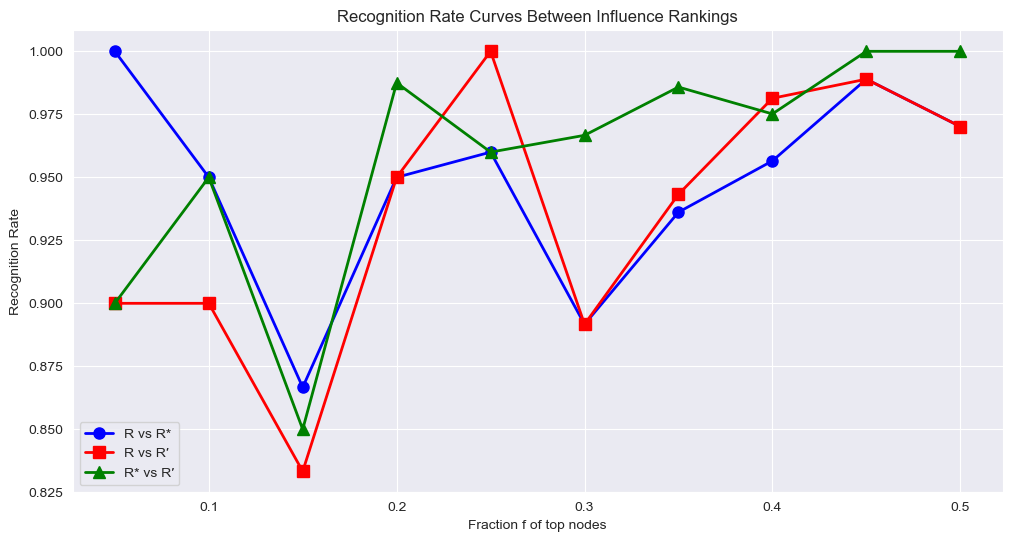

In [64]:
plt.figure(figsize=(12,6))
plt.plot(f_values, rR_Rstar_values, marker='o', color='blue', label="R vs R*", linewidth=2, markersize=8)
plt.plot(f_values, rR_Rprime_values, marker='s', color='red', label="R vs R′", linewidth=2, markersize=8)
plt.plot(f_values, rRstar_Rprime_values, marker='^', color='green', label="R* vs R′", linewidth=2, markersize=8)
plt.xlabel("Fraction f of top nodes")
plt.ylabel("Recognition Rate")
plt.title("Recognition Rate Curves Between Influence Rankings")
plt.legend()
plt.grid(True)
plt.show()

### Observations

1. At low fractions of nodes (f= 0.1), the recognition rate for the different influence rankings are close to 1, indicating no disagreement. This is because the top nodes are usually the most influential nodes and do not vary widely across different rankings.

2. However, as the fraction of nodes increases, there tends to be more disagreements. This can be explained because the influence rankings tend to look at different factors: R focuses on reaching 80% of the network, R* focuses on nodes that are quick to infect nearby local nodes (20%) and R' focuses on the average time to reach 80% of the network. 

3. Since R focuses on global network coverage while R* focuses on local network coverage, they tend to disagree as fraction of nodes being considered increases.

4. Since both R* and R' reward early-phase coverage, they might agree more with respect to the nodes being considered.